<a href="https://colab.research.google.com/github/ibrahim7860/emotiongpt/blob/clean_backend/emotionGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Need to do:
  add noise to data to prevent overfit
  mess around w/ batch size & epochs
  (run this)

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import warnings
# don't need maybe
from google.colab import drive

# 新段落

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = "/content/gdrive/MyDrive/Kaggle"

os.environ['KAGGLE_CONFIG_DIR'] = path
os.chdir(path)


Use np.load("filename") to retrieve np file information

---

use pd.read_pickle('filename') to retrieve dataframe


In [ ]:
emotions_to_labels = {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'neutral':4, 'sad':5, 'pleasant':6}
labels_to_emot = {v: k for k, v in emotions_to_labels.items()}  # wanted bidirectional mapping, this was an easy thing to do
spects_feature_np = np.load("Spectrogram Features.npy")
data_labels_np = np.load("Data Labels.npy")
df = pd.read_pickle('Dataframe.csv')

btw there is 14 subfolders for this dataset each with 200 entries.
The order is the older actress w/ each 7 emotions then the younger one.
(i.e. OAF_Fear, OAF_Pleasant, ..., OAF_neutral, YAF_angry, ..., YAF_sad)

df format is [speech, actors, labels, words, spectrogram]
spectrogram as a numpy array is 128x128.
pandas currently is only saving as a list (need to find a way to save multidimensional arrays for each entry)

These are quick methods to plot waveplots & spectrograms

In [ ]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
     x = librosa.stft(data)
     xdb = librosa.amplitude_to_db(abs(x))
     plt.figure(figsize=(11,4))
     plt.title(emotion, size=20)
     librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
     plt.colorbar()


Use tf.keras.models.load_model('filename') to retrieve

---

use train_history=np.load('emotionGPT history.npy',allow_pickle='TRUE').item()

Made assumption for name of the model/history stuff

In [ ]:
model = tf.keras.models.load_model('emotionGPT model.h5')
train_history = np.load('emotionGPT history.npy',allow_pickle='TRUE').item()

In [ ]:
def plot_model(train_history):
  plt.plot(train_history['val_accuracy'])
  plt.plot(train_history['accuracy'])
  plt.title('emotionGPT Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch #')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

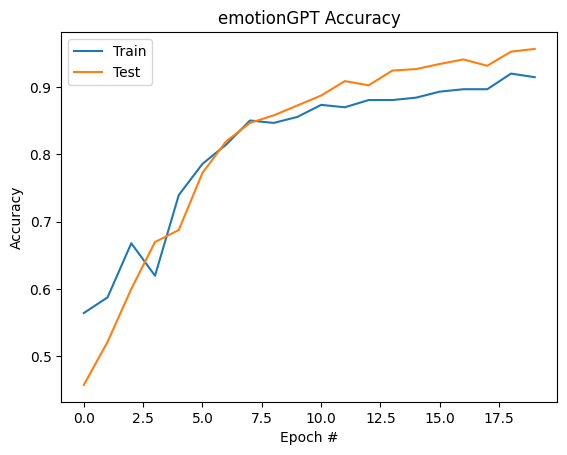

In [ ]:
plot_model(train_history)

In [ ]:
def resize_extract(audio_wav):
  new_check_audio, new_check_sr = librosa.load(audio_wav, sr=None, mono=True)
  # Extract Mel spectrogram features
  check_mel_spec = librosa.feature.melspectrogram(y=new_check_audio, sr=new_check_sr, n_fft=2048, hop_length=512, n_mels=128)
  check_mel_spec = librosa.power_to_db(check_mel_spec, ref=np.max)
  # Resize to 128x128
  check_mel_spec.resize((128,128), refcheck=False)
  # Resize for model
  check_mel_spec = check_mel_spec.reshape(-1,128,128,1)
  return check_mel_spec

In [ ]:
def get_label(check_mel_spec):
  result = model.predict(check_mel_spec)
  prob_arr = np.array(result)
  np.set_printoptions(precision=10, suppress=True)
  max_val = np.max(prob_arr)
  max_index = np.argmax(prob_arr)
  max_emotion = list(emotions_to_labels.keys())[list(emotions_to_labels.values()).index(max_index)]
  return max_val, max_emotion

Testing-ify

---

This is the newer stuff that needs to be changed & what not

In [ ]:
test = df['speech'][1200]
test_mel_spec = resize_extract(test)
probability, emotion_label = get_label(test_mel_spec)
print(f"The largest number is: {probability}")
print(f"Corresponding emotion is '{emotion_label}'")

1/1 [==============================] - 0s 53ms/step
The largest number is: 0.9999878406524658
Corresponding emotion is 'neutral'


In [ ]:
from flask import Flask, request

app = Flask(__name__)

# Define a route for the endpoint that will receive audio input and return the predicted emotion
@app.route('/predict-emotion', methods=['POST'])
def predict_emotion():
    # Get the audio input from the request
    audio_file = request.files['audio']

    new_test_audio, new_test_sr = librosa.load(audio_file, sr=None, mono=True)
    # Extract Mel spectrogram features
    test_mel_spec = librosa.feature.melspectrogram(y=new_test_audio, sr=new_test_sr, n_fft=2048, hop_length=512, n_mels=128)
    test_mel_spec = librosa.power_to_db(test_mel_spec, ref=np.max)
    # Resize to 128x128
    test_mel_spec.resize((128,128), refcheck=False)
    # Resize for model
    test_mel_spec = test_mel_spec.reshape(-1,128,128,1)

    check = spects_feature_np[0].reshape(-1,128,128,1)

    result = model.predict(check)

    arr = np.array(result)
    np.set_printoptions(precision=10, suppress=True)
    emotions_to_labels = {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'neutral':4, 'sad':5, 'pleasant':6}
    max_val = np.max(arr)
    max_index = np.argmax(arr)
    max_emotion = list(emotions_to_labels.keys())[list(emotions_to_labels.values()).index(max_index)]

    # Return the predicted emotion
    return max_emotion

# Run the Flask app
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)

In [ ]:
import requests

url = 'http://localhost:5000/predict-emotion'
files = {'audio': open('/content/drive/MyDrive/Kaggle/angry.wav', 'rb')}
response = requests.post(url, files=files)

print(response.text)